In [ ]:
# ! pip install -r requirements.txt

In [5]:
from typing import Optional

import abc
import numpy as np
import math
import pandas as pd

from sklearn.preprocessing import LabelEncoder

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# data_path = 'drive/MyDrive/shad_ml_sem/'
data_path = 'data/'
log_name = 'interactions.csv'
u_features_name = 'users.csv'
i_features_name = 'items.csv'

In [8]:
SEED = 123
K=10

# Рекомендательные системы

Обсудим задачи рекомендательных систем и особенности данных. 
Поговорим о метриках и моделях и попробуем реализовать некоторые из них самостоятельно.

# Содержание
- Датасет
    - типы feedback
    - что можно рекомендовать?
- Как влияет на решение задачи рекомендаций предметная область и поведение пользователей?
- EDA
- 0 Фильтрация данных
- 1 Разбиение данных
- 2 Простейшая рекомендательная система
- 3 Класс-рекомендатель
- 4 Оценка качества рекомендаций: Метрики качества и разнообразия
- 5 Еще раз о разбиении данных
- 6 Item-to-item модель на примере ассоциативных правил
- Модели для задачи рекомендаций top-k объектов для пользователя
    - 7 SVD
    - 8 LightFM
- 9 Двухуровневая модель (SVD + CatBoost)
- Нейросетевые модели
    - 10 MiltVAE

# Датасет

Будем использовать датасет [MTS Library](https://www.kaggle.com/sharthz23/mts-library), содержащий данные о истории чтения книг пользователями МТС Библиотеки.

### Предобработка

In [75]:
df = pd.read_csv(data_path+log_name, sep=',')

In [76]:
assert df.shape[0] == 1533078

In [77]:
%%time
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

u_features = pd.read_csv(data_path+u_features_name, sep=',')
i_features = pd.read_csv(data_path+i_features_name, sep=',')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

CPU times: user 556 ms, sys: 115 ms, total: 671 ms
Wall time: 676 ms


In [78]:
%%time
# конвертируем id пользователей и item-ов в подряд идущие номера
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(pd.concat([df['user_id'], u_features['user_id']]).values)
item_encoder.fit(pd.concat([df['item_id'], i_features['item_id']]).values)

CPU times: user 213 ms, sys: 13.4 ms, total: 226 ms
Wall time: 226 ms


LabelEncoder()

In [79]:
%%time
df['user_id'] = user_encoder.transform(df['user_id'])
df['item_id'] = item_encoder.transform(df['item_id'])

CPU times: user 620 ms, sys: 26.6 ms, total: 647 ms
Wall time: 648 ms


In [80]:
%%time
u_features['user_id'] = user_encoder.transform(u_features['user_id'])
u_features.set_index('user_id', inplace=True)

CPU times: user 9.61 ms, sys: 5.89 ms, total: 15.5 ms
Wall time: 13.8 ms


### Данные

In [81]:
u_features.head(2)

,age,sex
user_id,,
1,45_54,NaN
2,18_24,0.0


In [82]:
%%time
i_features['item_id'] = item_encoder.fit_transform(i_features['item_id'])
i_features.set_index('item_id', inplace=True)

CPU times: user 6.79 ms, sys: 4.89 ms, total: 11.7 ms
Wall time: 9.72 ms


In [83]:
i_features.head(2)

,title,genres,authors,year
item_id,,,,
23831,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
39149,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894


In [84]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Длина лога = {log.shape[0]},\nколичество пользователей = {log[user_id].nunique()},\nколичество объектов = {log[item_id].nunique()}')

In [85]:
df.head(5)

,user_id,item_id,progress,rating,start_date
0,126076,2656,80,NaN,2018-01-01
1437,96642,45603,1,NaN,2018-01-01
1436,47177,8687,54,NaN,2018-01-01
1435,94589,30787,6,NaN,2018-01-01
1434,109520,26294,86,NaN,2018-01-01


In [86]:
get_log_info(df)

Длина лога = 1532998,
количество пользователей = 151600,
количество объектов = 59599


In [94]:
f"Количество рейтингов = {(~df['rating'].isna()).sum()}, что сильно меньше, чем количество данных о прогрессе чтения ({(~df['progress'].isna()).sum()})"


'Количество рейтингов = 285337, что сильно меньше, чем количество данных о прогрессе чтения (1532998)'

## Особенности данных в задаче рекомендаций
- всегда есть id пользователей/сессий и объектов
- часто есть timestamp (знаем об изменениях предпочтений пользователей во времени)
- есть оценка релевантности объектов для пользователей

## Типы feedback
В нашем датасете есть progress - процент прочтения книги и rating - оценка, которую пользователь поставил. 
Это отличная иллюстрация для implicit и explicit feedback. Если пользователь поставил оценку, мы можем быть сильно уверены в том, насколько ему нравится книга. Но факт прочтения какой-то доли контента - тоже важный сигнал, и этой информации гораздо больше.

**Explicit**
- мало, но четко отражает предпочтения пользователя
- можно учить модели регрессии и ранжирования
- смещен в сторону "оценивает лучшая версия меня" (хоть мы и не говорим сегодня о вопросах психологии/этики)
- может быть двумодальное распределение (хочу похвалить или хочу поругать)

**Implicit**
- много
- разнородный
- часто не содержит негативного опыта/его надо извлекать на основе правил
- показывал реальные предпочтения пользователей

## Задачи

* предсказать для пользователя top-k релевантых объектов
* оценить релевантность выбранных пар пользователь-объект / переранжировать объекты для пользователя
* найти похожие объекты/похожих пользователей
* рекомендовать к сессии/корзине/товару

# Как влияет на решение задачи рекомендаций тип объектов и поведение пользователей?
Различных моделей для решения задачи рекомендаций - много, идеального способо выбрать нужную модель нет, но можно попробовать хотя бы определить тип. 
Пока датасет загружается/пакеты устанавливаются, поговорим о том, насколько разной может быть задача рекомендаций с точки зрения скорости изменения интересов пользователей и скорости устаревания объектов.
Придумайте какие-нибудь примеры рекомендательных систем, и попробуйте расположить их на графике:

In [9]:
%%html
<iframe src="https://drive.google.com/file/d/10XsrZ_c5wvTTVv3no835aLRNs_fWvFdD/preview" width="640" height="480" allow="autoplay"></iframe>

Кроме скорости устаревания можно придумать еще несколько факторов, влияющих на то, какую рекомендательную систему строить:

- сколько item-ов есть и насколько они похожи?
- item-ы потребляются один раз или с какой-то частотой?
- важна ли последовательность потребления (второй сезон сериала после первого)?
- логинятся ли пользователи при посещении сайта?
- нужно ли реагировать онлайн или достаточно посчитать рекомендации один раз в сутки?

К чему этот график выше? Чтобы понять, какие модели точно не подойдут, а какие стоит рассмотреть внимательнее.

Глобально по типу используемых данных можно выделить:
- классические модели, основанные на логе взаимодествия
- сontent-based (используют сходство признаков объектов/пользователей)
- Hybrid/Ansamblies (сложные/использующие как лог, так и признаки, включающие несколько моделей)


Плюс на графике отмечены еще session-based (используют данные сессий отдельных пользовательских сессий, а не всю историю)

ps: это не классификация всех возможных рекомендательных моделей, а просто выделение некоторых групп для понимания, почему не любую задачу можно решить ALS-ом)

In [87]:
%%html
<iframe src="https://drive.google.com/file/d/1-dRZaq3OOY1w-M8bHGF3ldCOYZ-uWVId/preview" width="640" height="480" allow="autoplay"></iframe>

# EDA

## Распределение рейтинга и доли прочтения

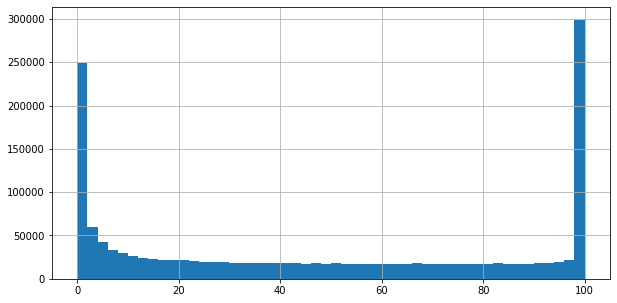

In [22]:
df['progress'].hist(bins=50, figsize=(10, 5));

Либо бросают быстро, либо дочитывают до конца

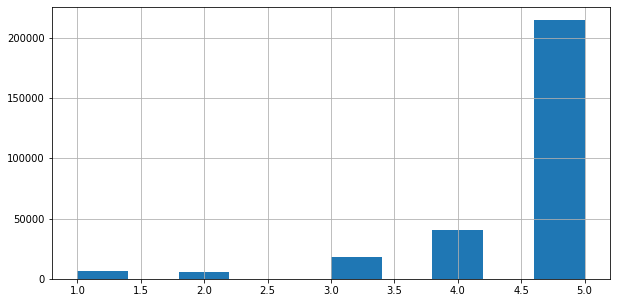

In [23]:
df['rating'].hist(bins=10, figsize=(10, 5));

 Оценивают понравившееся 

In [24]:
df['rating'].value_counts()

5.0    214703
4.0     40382
3.0     18273
1.0      6115
2.0      5864
Name: rating, dtype: int64

## Распределение числа прочтений у пользователя / книги

In [25]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title);
    return grouped

count    151600.000000
mean         10.112124
std          20.922963
min           1.000000
5%            3.000000
25%           5.000000
50%           7.000000
75%          10.000000
95%          20.000000
max        2091.000000
Name: progress, dtype: float64


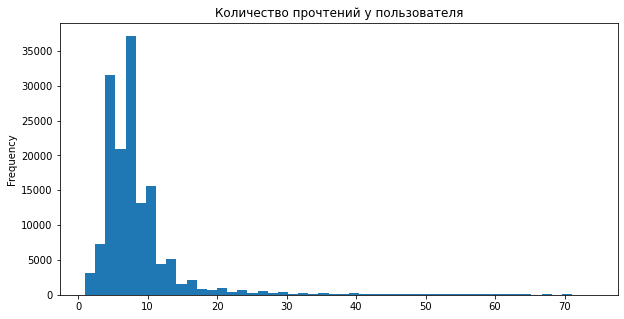

In [26]:
user_count = group_by_and_plot(df, group_by_name='user_id', rating_col_name='progress', quantile=0.99, title='Количество прочтений у пользователя')

count    59599.000000
mean        25.721875
std         60.665733
min          2.000000
5%           9.000000
25%         13.000000
50%         16.000000
75%         21.000000
95%         65.000000
max       6575.000000
Name: progress, dtype: float64


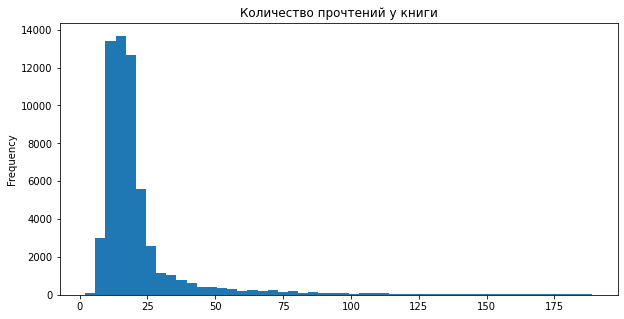

In [27]:
item_count = group_by_and_plot(df, group_by_name='item_id', rating_col_name='progress', quantile=0.99, title='Количество прочтений у книги')

Данные довольно плотные, у 95% пользователей более трех взаимодействий, у 95% книг более 9 прочтений

count    101885.000000
mean          2.800579
std          10.026988
min           1.000000
5%            1.000000
25%           1.000000
50%           1.000000
75%           2.000000
95%           5.000000
max         691.000000
Name: rating, dtype: float64


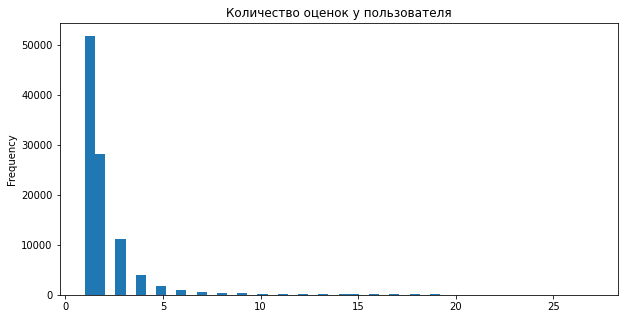

In [28]:
user_count = group_by_and_plot(df[~df['rating'].isna()], group_by_name='user_id', rating_col_name='rating', quantile=0.99, title='Количество оценок у пользователя')

Оценок гораздо меньше. Часто мы не хотим что-то рекомендовать человеку на основании одной оценки или строить матричные разложения/учить сетки на супер-разреженных данных, и поэтому используем implicit feedback.

<a id='filter'></a>
# 0 Фильтрация данных

Будем использовать историю чтения книг, а не оценки, так как этих данных больше и они могут лучше характеризовать актуальные предпочтения пользователей. 

Что такое релевантная книга по доле прочитанного? Прочитанная на 100%? А если на 60%?
Самы простой способ - отталкиваться от бизнес-требований и бизнес-метрик. У нас нет бизнес-задачи, поэтому придумаем сами!


### Оставим взаимодействия с progress > 50

In [112]:
filtered_df = df[df['progress'] > 50]

In [113]:
get_log_info(filtered_df)

Длина лога = 712368,
количество пользователей = 143465,
количество объектов = 59560


### Удалим объекты с менее 3 взаимодействиями и пользователей с менее 5 взаимодействиями

Облегчим себе жизнь и уменьшим размеры датасета. В индустрии и академии тоже так делают)

1) оставьте в filtered_df книги с 3 и более взаимодействиями, 

2) после этого оставьте в filtered_df пользователей с 5 и более взаимодействиями

In [114]:
item_counts = filtered_df.groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 2]
filtered_df = filtered_df[filtered_df['item_id'].isin(pop_items.index)]

In [115]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 4]
filtered_df = filtered_df[filtered_df['user_id'].isin(pop_users.index)]

In [116]:
get_log_info(filtered_df)

Длина лога = 446121,
количество пользователей = 37004,
количество объектов = 56752


In [117]:
assert filtered_df.shape[0] == 446121
assert filtered_df['user_id'].nunique() == 37004

# 1 Разбиение данных

Как построить локальную валидацию? 
Опять же, исходя из реальной задачи. В реальности у нас есть срез истории взаимодействия в прошлом и мы хотим предсказать предпочтения пользователей в будущем.
В статьях разных лет используются:
- случайное разбиение
- случайное внутри истории пользователя (k item-ов каждого пользователя в test)
- leave-one-out / leave-k-out  по времени
- time-based (например, взаимодействия в течение будующих 7 дней)

Почему плохо разбивать без учета timestamp? 

Реализуем time-based разбиение, оставим в test только активных пользователей и возьмем первые K взаимодействий.

In [118]:
%%html
<iframe src="https://drive.google.com/file/d/1L7dgH9lMYHBpxPASPJEUjm8U3_f9VrdQ/preview" width="640" height="480" allow="autoplay"></iframe>

Вообще лучше не ограничиваться одним сплитом, а делать blocking time series cross-validation (но не будем)

![blocking cv](https://hub.packtpub.com/wp-content/uploads/2019/05/Blocking-Time-Series-Split.png)

## Разобъем датасет на train и test по 80-му перцентилю timestamp

In [119]:
train_by_date = filtered_df[filtered_df['start_date'] <= filtered_df['start_date'].quantile(0.8)]
test_by_date = filtered_df[filtered_df['start_date'] > filtered_df['start_date'].quantile(0.8)]

In [120]:
assert train_by_date.shape[0] == 357518
assert test_by_date.shape[0] == 88603

## Оставим в test только пользователей, у которых в test 5 и более взаимодействий и возьмем первые 5 из них

In [125]:
counts_in_test = test_by_date.groupby('user_id')['item_id'].count()
test_by_date = test_by_date[test_by_date['user_id'].isin(counts_in_test[counts_in_test > 4].index)]
test_by_date['rank'] = test_by_date.groupby('user_id')['start_date'].rank(method="first", ascending=True)
test_by_date = test_by_date[test_by_date['rank'] <= 5].drop(columns=['rank'])

# удалим холодных пользователей
test_by_date = test_by_date[test_by_date['user_id'].isin(train_by_date['user_id'].unique())]
test_by_date_users = test_by_date['user_id'].drop_duplicates()

In [122]:
assert test_by_date.shape[0] == 15230

In [123]:
get_log_info(train_by_date)

Длина лога = 357518,
количество пользователей = 36823,
количество объектов = 55098


In [124]:
get_log_info(test_by_date)

Длина лога = 15230,
количество пользователей = 3046,
количество объектов = 7825


# 2 Первая модель - рекомендуем популярное

Самый простой рекомендатель - модель, которая будет рекомендовать популярные книги (книги, которые чаще всего читали). Построим такую модель.

## 2.1 Задание: посчитайте популярность (число пользователей, читавших книгу, к общему числу пользователей) книг по train-датасету и выведите топ-10 самых популярных книг с названиями. 

In [203]:
# ======= YOUR CODE HERE ==========
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
popularity /= train_by_date['user_id'].nunique()

In [204]:
assert math.isclose(popularity[16683], 0.016050, abs_tol=1e-6)

In [205]:
pd.DataFrame(popularity).merge(i_features, on='item_id').head(10)

,popularity,title,genres,authors,year
item_id,,,,,
16683,0.016050,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015
59157,0.013633,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05
49181,0.012791,После,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014
22649,0.012709,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007
20939,0.010673,После ссоры,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014
50905,0.010591,Чистовик,Научная фантастика,Сергей Лукьяненко,2007
46704,0.010401,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
29612,0.008663,Пятьдесят оттенков серого,"Эротические романы,Зарубежные любовные романы",Э. Л. Джеймс,2012
18388,0.008500,"Сила подсознания, или Как изменить жизнь за 4 ...","Практическая эзотерика,Эзотерика / оккультизм,...",Джо Диспенза,2013


### Первая книга - Зулейха открывает глаза? Значит все ок. Поздравляю, вы написали первую рекомендательную систему!

Что не так?
- Мы все-таки хотим предсказывать для пользователя, и хотим отфильтровать уже прочитанные им книги
- Хотим получить predict для пользователей в виде датарфейма с колонками `user_id - item_id - relevance`
- Хотим уметь получать нужное количество рекомендаций для каждого пользователя
- Хотим в конце концов делать fit - predict!

Поэтому сделам базовый класс для рекомендателя, и будем наследовать от него наши алгоритмы.

# 3 Класс ParentModel

## 3.1 Задание: посмотрите на код ниже и убедитесь, что вы поняли, 
- как работают leave_top_k и _filter_seen
- что делает predict
- что predict вызывает _predict, в котором уже реализуется логика predict моделью

In [138]:
from copy import deepcopy

In [139]:
def leave_top_k(pred: pd.DataFrame, 
                 k: int,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred


def filter_seen_items(log: pd.DataFrame, 
                 pred: pd.DataFrame) -> pd.DataFrame:
    """
    filter pairs `user-item` present in log out of pred
    """
    log_filtered = log[log['user_id'].isin(pred['user_id'].unique())]
    pred = pred.merge(log_filtered[['user_id', 'item_id']].drop_duplicates(), 
                                on=['user_id', 'item_id'], 
                                how='outer', 
                                indicator = True)
    return pred[pred['_merge'] == 'left_only'].drop(columns=['_merge'])


class ParentModel:
    @abc.abstractmethod
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None):
        """
        fit recommender
        
        Parameters
        ----------
        log : pandas dataframe with columns [user_id, item_id, timestamp, relevance]
        user_features : pandas dataframe with column `user_id` and features columns
        item_features : pandas dataframe with column `item_id` and features columns

        Returns
        -------
        
        """
    
    
    def predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen: bool = True) -> pd.DataFrame:
        """
        predict with fitted model, filter seen and crop to top-k for each user
        
        Parameters
        ----------
        log: pandas dataframe with columns [user_id, item_id, timestamp, relevance]
            used to filter seen and to make predictions by some models
        users: user ids to recommend for
        k: number of recommendations for each user
        user_features: pandas dataframe with column `user_id` and features columns
        item_features: pandas dataframe with column `item_id` and features columns
        filter_seen: if True, items present in user history are filtered from predictions

        Returns
        -------
        pandas dataframe with columns [user_id, item_id, relevance] 
            top-k recommended items for each user from `users`.
        """
        
        # overhead
        max_items_in_train = log.groupby('user_id')[['item_id']].count().max()[0] if filter_seen else 0
        
        pred = self._predict(
            log=log,
            users=users, 
            k=max_items_in_train+k,
            user_features=user_features, 
            item_features=item_features,
            filter_seen=filter_seen)
        if filter_seen:
            pred = filter_seen_items(log, pred)
            
        return leave_top_k(pred, k)
    
    
    @abc.abstractmethod    
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        """
        predict with fitted model
        """

## Модель для рекомендаций популярного
- допишите fit. Сохраните популярность объектов в атрибуте items_popularity
- допишите _predict (фильтрацию просмотренных за вас потом сделает predict). 

relevance = популярность книги, число пользователей, читавших книгу, к общему числу пользователей

In [206]:
class PopularModel(ParentModel):
    items_popularity: pd.DataFrame
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'PopularModel':
        # ======= YOUR CODE HERE ==========
        self.items_popularity = log.groupby('item_id')['user_id'].count().sort_values(ascending=False).rename('popularity') / log['user_id'].nunique()
        # =================================
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        # ======= YOUR CODE HERE ==========
        users_to_join = pd.DataFrame(users)
        users_to_join['key'] = 0
        pred = pd.DataFrame({'item_id': self.items_popularity[:k].index.to_list(),
                     'relevance': self.items_popularity[:k].values})
        pred['key'] = 0
        return users_to_join.merge(pred, on='key', how='outer').drop(columns=['key']).reset_index(drop=True)
        # =================================


In [207]:
%%time
rec = PopularModel()
rec.fit(train_by_date)

CPU times: user 27.3 ms, sys: 6.94 ms, total: 34.3 ms
Wall time: 31.8 ms


In [208]:
%%time
pred = rec.predict(log=train_by_date, users=test_by_date_users, k=K, filter_seen=True)

CPU times: user 1.57 s, sys: 685 ms, total: 2.26 s
Wall time: 2.42 s


In [209]:
pred.head(11)

,user_id,item_id,relevance
0,112167,16683,0.016050
1,112167,59157,0.013633
2,112167,49181,0.012791
3,112167,22649,0.012709
4,112167,20939,0.010673
5,112167,50905,0.010591
6,112167,46704,0.010401
7,112167,29612,0.008663
8,112167,18388,0.008500
9,112167,50385,0.008337


In [210]:
assert pred.shape[0] == test_by_date_users.shape[0] * K
assert (pred.groupby('user_id')['item_id'].count() == K).all()
assert pred['item_id'].nunique() > K

## Улучшение рекомендаций популярного
Мы рекомендовали популярное, это максимально простая модель, у которой могут быть простые улучшения, например, можно подобрать период, за который берутся данные или учитывать более "свежие" взаимодействия с большим весом.

# 4 Метрики

Как понять, что понравится пользователю? Для максимальной достоверности - порекомендовать и посмотреть на его поведение (кликнет/купит/посмотрит ли рекомендованные айтемы). 

Но жизнь устроена по-другому!

A/B-тестирование - честно, но:
- дорого
- сложно
- рисковано
- не походит для прототипирования.

A/B на синтетических данных:
- не научились пока качественно моделировать поведение пользователей

Поэтому в первую очередь для оценки качества применяются offline эксперименты, и измеряют offline-метрики.

Метрики качества:
- регрессионные метрики (RMSE, MAE)
- метрики классификации и ранжирования (precision, recall, Mean Average Precision, NDCG)

Метрики разнообразия:
- coverage, surprisal, diversity, ets

In [146]:
from rs_metrics import mapr

## Реализуем несколько метрик, специфичных для рекомендательных систем

Метрики в рекомендациях часто рассчитываются для каждого пользователя для top-к рекомендаций, в ground truth при этом учитываются все релевантные объекты, а не только top-К. Затем метрики усредняются по пользователям.

## HitRate
 = 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе
 
## 4.1 Посмотрите на подсчет hit rate для одного пользователя

In [157]:
def user_hr(row):
    '''
    Caclulate HitRate value for pandas row with user_id, a list of ground truth items in ``gt_items``
    and list or recommended items in ``pred_list``.
    '''
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [158]:
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]})) == 1
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': [4, 5, 2, 6]})) == 0
assert user_hr(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]})) == 0

## 4.2 Посмотрите на функцию-обертку, которая будет приводить данные в нужный формат, вызывать нужную метрику и считать среднее
Перед реализацией подсчета метрики для всех пользователей подумайте:

1) Как должны учитываться в метриках пользователи, для которых мы что-то предсказали, но в test они отсутствуют (ничего не купили / не начали читать / вообще не пользовались сервисом)?

2) Как должны учитываться пользователи, которые есть в test, но мы не смогли получить для них предсказания (например, модель не предсказывает для холодных)

3) Как повлияют на значение метрик пользователи с очень длинной и очень короткой историей в test? Какой самый простой способ бороться с влиянием этих пользователей на значения метрик?

In [159]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    '''
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').
    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    '''
    # ======= YOUR CODE HERE ==========    
    pred_cropped = leave_top_k(pred, k)
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # ==================================
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [160]:
metric_all, table_ = metric_wrap(pred, test_by_date, k=K, metric_by_user=user_hr)
assert math.isclose(metric_all, 0.022324, abs_tol=1e-6)

In [161]:
metric_part, table_ = metric_wrap(pred[:1000], test_by_date, k=K, metric_by_user=user_hr)
assert metric_part < metric_all

## MRR@K 
- обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. Если релевантных рекомендаций нет, равен нулю.



## 4.3 Задание: реализуйте подсчет mrr для одного пользователя

In [162]:
def user_mrr(row):
    '''
    Caclulate MRR value for pandas row with list of ground truth items in ``gt_list``
    and list or recommended items in ``pred_list``.
    '''
    # ======= YOUR CODE HERE ==========
    for rank, item in enumerate(row['pred_list']):
        if item in row['gt_list']:
            return 1 / (rank + 1)
    return 0

In [163]:
assert user_mrr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]})) == 1/2
assert user_mrr(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': []})) == 0

# Другие требования к рекомендательным системам и метрики

Другие свойства рекомендательных систем, которые хотят измерять и учитывать при выборе решения: 
- *Coverage* - доля item-ов, учитываемых в рекомендациях, 
- confidence - уверенность в качестве рекомендаций со стороны системы (можем ли оценить степерь уверенности модели в рекомендациях? велика ли она для всех пользователей?), 
- trust - доверяют ли пользователи рекомендательной системе?
- *novelty/surprisal* - степень новизны рекомендаций (пользователь не знает о существовании контента)
- *diversity* - разнообразие рекомендаций,
- *serendipity* - мера неожиданности полезных рекомендаций

In [164]:
%%html
<iframe src="https://drive.google.com/file/d/1XOQpr9C0EjtfmzeOhJOFFjJhV1zzP2co/preview" width="640" height="480" allow="autoplay"></iframe>

 - utility - польза для пользователей и владельцев сервиса, 
 - robustness - стабильность при наличии fake information, 
 - privacy - "people who bought this book also bought" не выдает интересов конкретного пользователя
 - adaptivity - быстрота учета фидбэка, 
 - scalability

<i>source: Francesco Ricci • Lior Rokach • Bracha Shapira, Recommender Systems Handbook, 2015</i>


+ Не хотим рекомендовать кликбейт/контент для взрослых, 
+ хотим учитывать особенности законодательства
+ fairness
+ борьба с bias и feedbaсk loop

О том, какие метрики надо использовать, и как правильно их считать, до сих пор ведутся научные дискуссии и пишутся статьи.
Например, [статья с recSys2021](https://dl.acm.org/doi/abs/10.1145/3460231.3478848) про то, что все считают метрики по-разному, называя их одинаково.
Или [другая статья](https://dl.acm.org/doi/10.1145/3460231.3474234) с той же конференции, предлагающая способ учесть качество и разнообразие выдачи с помощью одной метрики $\alpha\beta$-ndcg.

## Coverage
Оценим насколько такие рекомендаци хороши с точки зрения разнообразия, и для этого реализуем метрику coverage, которая определяется как доля объектов, которые модель в принципе способна порекомендовать. На практике, для сравнения нескольких алгоритмов, может реализовываться как доля объектов, присутствующих в выдаче.

## 4.4 Реализуйте подсчет coverage
Обратите внимание, что эта метрика не требует ground truth и считается сразу по всем пользователям

In [168]:
def coverage(pred, k, all_items):
    # ======= YOUR CODE HERE ==========
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

In [169]:
cov = coverage(pred, K, train_by_date['item_id'])

In [170]:
%%time
assert math.isclose(cov, 0.000308, abs_tol=1e-6)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


У рекомендаций популярного ожидаемо низкий coverage. Посмотрим, как он будет меняться при использовании других моделей.

## Surprisal (Mean Inverse User Frequency, Mean Self-Information)
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$ 
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результ усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант - считать, что для них было взаимодействие с одним пользователем.

## 4.5 Реализуйте подсчет surprisal
Обратите внимание, что эта метрика не требует ground truth, но требует предпосчитанных популярностей item-ов

In [195]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        self.num_users = log['user_id'].nunique()
        self.item_pop = (log.groupby('item_id')[['user_id']].count() / self.num_users).rename(columns={'user_id':'rel'})

    def __call__(self, pred, k):
        '''
        Caclulate Surprisal value for ``pred`` with pre-calculated items' popularities
        '''
        # ======= YOUR CODE HERE ==========
        top_k_recs = leave_top_k(pred, k)
        matrix = top_k_recs[['item_id', 'user_id']].merge(self.item_pop, left_on='item_id', right_index=True, how='left').fillna(1 / self.num_users)
        matrix.loc[:, 'rel'] = - np.log2(matrix['rel'])
        user_self_inf = matrix.groupby('user_id')['rel'].sum()
        user_self_inf /= k * np.log2(self.num_users)
        return user_self_inf.mean()

In [196]:
surp = Surprisal(train_by_date)

In [197]:
assert math.isclose(surp(pred, K), 0.429753, abs_tol=1e-6)

## Подсчет всех метрик

In [84]:
def measure(pred, true, name, df=None, cov_items=None, surp=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@1', 'hit_rate@K', 'mrr@K', 'map@K', 'coverage@K', 'surprisal@K'])
    df.loc[name, 'hit_rate@1'] = metric_wrap(pred=pred, ground_truth=true, k=1, metric_by_user=user_hr)[0]
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'mrr@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_mrr)[0]
    df.loc[name, 'map@K'] = mapr(true=true, pred=pred, k=K)
    if cov_items is not None:
        df.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    if surp is not None:
        df.loc[name, 'surprisal@K'] = surp(pred=pred, k=K)
    return df
    

In [86]:
%%time
metrics = measure(pred, test_by_date, 'popular', cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 990 ms, sys: 64.2 ms, total: 1.05 s
Wall time: 1.96 s


In [87]:
metrics

,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.531123


# 5 item-to-item модели
item-to-item подходы отлично работают, когда мы хотим, например, напрямую рекомендовать товары к выбранному пользователем (похожие или сопутствующие). Кроме того, item-to-item методы можно использовать, чтобы рекомендовать товары к корзине в интернет-магазине или музыкальные треки к истории пользователя.

частично item-to-item модели были рассмотрены на семинаре по ранжированию на примере [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html)

примеры item-to-item моделей:
- поиск ближайших item-ов по признакам
- любой классификатор, обучающийся на датасете "признаки пользователя/сессии - признаки текущего item-а - признаки следующего item-а" с target "появился ли в сессии следующим"
- item-to-item knn на истории взаимодействий
- модели на базе ассоциативных правил
- [нейронка item2vec от avito](https://habr.com/ru/company/avito/blog/491942/)

# Рекомендации на основе ассоциативных правил

Теперь рассмотрим простой подход, который позволяет находить группы объектов, втречающиеся вместе - ассоциативные правила.
Пусть у нас есть просматриваемый товар $a$ (antecedent), к которому мы хотим предложить ассоциированный товар $b$ (consequent).

Support - доля пользователей/сессий, в которых встречается объект.
$$Support(a) = \frac{|a \subseteq n|}{|n|} = p(a)$$

Confidence - это условная вероятность повления $b$ при наличии $a$. 
$$Confidence(a, b) = \frac{support(a, b)}{support(a)} = p(b | a)$$ 

Кажется, этого может быть уже достаточно, чтобы рекомендовать $b$ к $a$. Но, например, $b$ - это бананы, которые в принципе часто покупают, а $a$ - супер-крутое миндальное молоко, которое покупают редко, и которое не связано с бананами. Их все равно относительно часто покупали вместе, потому что без бананов никуда, и Confidence  получится большим. Рекомендовать бананы ко всему - плохая идея. Поэтому для построения рекомендаций используют метрику $lift$, которую можно интерпретировать как меру того, насколько появление объекта $a$ увеличивает вероятность появления объекта $b$.


$$Lift(a, b) = \frac{Confidence(a, b)}{support(b)} = \frac{p(b|a)}{p(b)}$$

$a$ может быть не отдельным объектом, а подмножеством, и задача подсчета Lift становится вычислительно сложной.
Для быстрого поиска [ассоциативных правил](https://en.wikipedia.org/wiki/Association_rule_learning) придумано довольно большое число алгоритмов, например [Apriori](https://en.wikipedia.org/wiki/Apriori_algorithm), FP-Growth.

Из явных минусов - ассоциативные правила не учитывают сходства объектов, и плохо подходят в случае, когда объектов много, а взаимодействий - нет.

## 6.1 Задание: напишите код, который
- по логу считает встречаемость айтемов, 
- отсекает пары айтемов с количеством меньше min_support
- считает confidence, lift
- возвращает датафрейм со столбцами item_id_x, item_id_y, pair_count, confidence, lift

In [92]:
def get_item_to_item_lift(log, min_support):
    # ======= YOUR CODE HERE ==========
    num_users = log['user_id'].unique().shape[0]
    items_counts = log.groupby('item_id')['item_id'].count()
    
    coocurance = log[['user_id', 'item_id']].merge(log[['user_id', 'item_id']], on='user_id')
    coocurance = coocurance[coocurance['item_id_x']  != coocurance['item_id_y']]
    coocurance = coocurance.drop(columns='user_id')
    
    counts = coocurance.groupby(['item_id_x', 'item_id_y'])['item_id_y'].count().rename('pair_count').reset_index()   
    counts = counts[counts['pair_count'] >= min_support]
    counts['item_id_x_count'] = counts['item_id_x'].map(items_counts)
    counts['item_id_y_count'] = counts['item_id_y'].map(items_counts)
    
    counts['confidence'] = counts['pair_count'] / counts['item_id_x_count']
    counts['lift'] = counts['confidence'] * num_users / counts['item_id_y_count']
    return counts

In [93]:
%%time
counts = get_item_to_item_lift(train_by_date, min_support=5)

CPU times: user 6.93 s, sys: 2.51 s, total: 9.44 s
Wall time: 9.65 s


In [94]:
assert counts.shape[0] == 577956
assert counts['lift'].max() == 7364.6

In [95]:
assert math.isclose(counts[(counts['item_id_x'] == 16683) & ((counts['item_id_y'] == 33452))]['lift'].values[0], 27.957937, abs_tol=1e-6)

Посмотрим на рекомендации для книги "Зулейха открывает глаза" (16683), отсортированные по confidence и lift.

In [96]:
i_features.loc[16683]

title             Зулейха открывает глаза
genres     Современная русская литература
authors                      Гузель Яхина
year                                 2015
Name: 16683, dtype: object

**Confidence** - видим разнообразные книги

In [97]:
res_by_confidence = counts[counts['item_id_x'] == 16683].sort_values('confidence', ascending=False)
res_by_confidence[:10][['item_id_y', 'confidence', 'lift']].merge(i_features, left_on='item_id_y', right_index=True)

,item_id_y,confidence,lift,title,genres,authors,year
3463807,33452,0.059222,27.957937,Дети мои,Современная русская литература,Гузель Яхина,2018
3460928,4883,0.057530,8.054802,Шантарам,Зарубежные приключения,Грегори Дэвид Робертс,2003
3462725,22649,0.057530,4.526523,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007
3462449,20021,0.055838,7.700774,Женщины непреклонного возраста и др. беспринцЫ...,"Современная русская литература,Юмористическая ...",Александр Цыпкин,2018
3465805,54115,0.054146,6.735812,Девушка в тумане,"Зарубежные детективы,Триллеры",Донато Карризи,2015
3466339,59157,0.050761,3.723482,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05
3461090,6565,0.049069,14.932905,Тысяча сияющих солнц,Современная зарубежная литература,Халед Хоссейни,2008
3465104,46704,0.043993,4.229668,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
3461462,10347,0.043993,10.384377,Вторая жизнь Уве,Современная зарубежная литература,Фредрик Бакман,2012
3463528,30629,0.038917,7.129572,Цветы для Элджернона,"Зарубежная фантастика,Научная фантастика",Дэниел Киз,1966


**Lift** - видим действительно похожие по жанру книги

In [98]:
res_by_lift = counts[counts['item_id_x'] == 16683].sort_values('lift', ascending=False)
res_by_lift[:10][['item_id_y', 'confidence', 'lift']].merge(i_features, left_on='item_id_y', right_index=True)

,item_id_y,confidence,lift,title,genres,authors,year
3463807,33452,0.059222,27.957937,Дети мои,Современная русская литература,Гузель Яхина,2018
3465348,49314,0.013536,24.922504,Авиатор,Современная русская литература,Евгений Водолазкин,2015
3462852,24011,0.010152,21.990445,Женщина в белом,"Зарубежная классика,Классическая проза",Уильям Уилки Коллинз,NaN
3464791,43720,0.011844,18.172659,Посмотри на него,Современная русская литература,Анна Старобинец,2017
3465737,53366,0.023689,17.801789,И эхо летит по горам,Современная зарубежная литература,Халед Хоссейни,NaN
3460538,1045,0.015228,16.992617,Женщины Лазаря,Современная русская литература,Марина Степнова,2011
3466252,58427,0.008460,16.396384,Пустые хлопоты,Современная русская литература,Мария Метлицкая,2017
3460791,3662,0.016920,15.975964,Казус Кукоцкого,Современная русская литература,Людмила Улицкая,2001
3460731,3081,0.018613,15.938811,Метель,Социальная фантастика,Владимир Сорокин,2010
3461423,9864,0.021997,15.576565,С неба упали три яблока,Современная русская литература,Наринэ Абгарян,2014


Любую item-to-item модель можно использовать для получение рекомендаций для пользователя. Имея вектора item-ов или расстояния/близости между ними, можно взять историю пользователя и рекомендовать близкие к item-ам из истории. 
## 6.2 Задание: допишите код модели, которая будет рекомендовать ближайших "соседей" к истории пользователя, используя lift в качестве меры близости, а именно: 
- к истории пользователя джойним матрицу lift, из которой взяты топ-к соседей для каждого item-а
- считаем relevance как количество раз, сколько встречаются объекты-соседи после join матриц (можно считать count, sum, sum(log(lift)), etc)

In [101]:
class NeighbourModel(ParentModel):
    pairs_lift: pd.DataFrame
        
    def __init__(self, min_support: int):
        self.min_support = min_support
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'NeighbourModel':
        self.pairs_lift = get_item_to_item_lift(log, self.min_support)
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        history = log.merge(users.drop_duplicates(), on='user_id')
        lift_martix = leave_top_k(self.pairs_lift, k,
                 group_by_col='item_id_x',
                 order_by_col='lift')
        
        # ======= YOUR CODE HERE ==========
        history = history.merge(lift_martix[['item_id_x', 'item_id_y', 'lift']], left_on='item_id', right_on='item_id_x')
        pred = history.groupby(['user_id', 'item_id_y'])['lift'].count().rename('relevance')
        pred = pred.reset_index().rename(columns={'item_id_y': 'item_id'})
        return pred

Полезный результат:
Мы можем переиспользовать этот код и построить модель для рекомендации пользователям на основе любой матицы сходства item-ов (например, используя сходство по признакам).

In [102]:
neighbour_rec = NeighbourModel(min_support=7)

In [103]:
%%time
neighbour_rec.fit(train_by_date)

CPU times: user 7.13 s, sys: 2.55 s, total: 9.69 s
Wall time: 9.81 s


In [104]:
%%time
neighbour_pred = neighbour_rec.predict(log=train_by_date, users=test_by_date_users, k=K)

CPU times: user 2.12 s, sys: 817 ms, total: 2.93 s
Wall time: 3.03 s


In [105]:
assert neighbour_pred.shape[0] == 19202

In [106]:
%%time
metrics = measure(neighbour_pred, test_by_date, 'neighbour_rec', metrics, cov_items=filtered_df['item_id'], surp=surp)
metrics.sort_values('map@K', ascending=False)

CPU times: user 1.02 s, sys: 290 ms, total: 1.31 s
Wall time: 2.26 s


,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.606857
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.531123


In [107]:
metrics.sort_values('map@K', ascending=False)

,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.606857
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.531123


Почему люди вообще должны считать какое-то отношение вероятностей в 21 веке? 
- Первое - потому что это работает само по себе на больших объемах данных, быстро учится и не требует ничего. 
- Второе - если сверху матрицы lift обучить какое-нибудь матричное разложение и использовать ann, можно бюджетно искать похожие item-ы без построения сложных моделей
- Третье - люди пишут, что делать матричное разложение на данных shifted pmi (pmi = log(lift)) - это вообще бюджетный способ [получить эмбеддинги, аналогичные word2vec](https://medium.com/radix-ai-blog/unifying-word-embeddings-and-matrix-factorization-part-1-cb3984e95141). 
- Ну и всем нужен хороший безйлайн!)

### Посмотрим глазами на predict-ы для выбранного пользователя

История пользователя 21:

In [108]:
train_by_date[(train_by_date['user_id'] == 21)].merge(i_features[['title', 'authors', 'year', 'genres']], left_on='item_id', right_index=True)

,user_id,item_id,progress,rating,start_date,title,authors,year,genres
249157,21,4375,54,NaN,2018-05-01,Выстрел в сердце,Герман Садулаев,2017,Современная русская литература
293131,21,5909,85,5.0,2018-05-22,Спектр,Сергей Лукьяненко,2001-02,"Социальная фантастика,Космическая фантастика,Н..."
707632,21,42197,100,NaN,2018-12-05,История Бледной Моли,Настя Любимка,2017,"Героическое фэнтези,Любовное фэнтези"
949315,21,13438,100,NaN,2019-03-30,Честь Белого Волка,Андрей Белянин,2018,Юмористическое фэнтези
983687,21,28402,100,NaN,2019-04-15,Свирепый ландграф,Андрей Белянин,1998,Юмористическое фэнтези
1074800,21,5795,99,NaN,2019-05-28,Век святого Скиминока,Андрей Белянин,1998,"Героическое фэнтези,Юмористическое фэнтези"
1194397,21,13389,100,NaN,2019-07-23,Страж,Алексей Пехов,2010,"Героическое фэнтези,Книги про волшебников"
1197382,21,39338,99,NaN,2019-07-24,Аутодафе,Алексей Пехов,2011,"Героическое фэнтези,Боевое фэнтези"
1207323,21,22637,100,5.0,2019-07-29,Золотые костры,Алексей Пехов,2012,"Героическое фэнтези,Боевое фэнтези"
1213766,21,7211,96,NaN,2019-08-01,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"


Predict:

In [109]:
neighbour_pred[neighbour_pred['user_id'] == 21].merge(i_features[['title', 'authors', 'year', 'genres']], on='item_id').sort_values('relevance', ascending=False)

,user_id,item_id,relevance,title,authors,year,genres
0,21,1036,8.0,Искатели ветра,Алексей Пехов,2005,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
3,21,12691,6.0,Ловушка для духа,"Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2016,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
5,21,27283,6.0,Созерцатель,Алексей Пехов,2016,"Стимпанк,Героическое фэнтези,Боевое фэнтези"
8,21,41344,6.0,Ветер полыни,Алексей Пехов,2006,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
6,21,31099,4.0,Ловцы удачи,Алексей Пехов,2012,Боевое фэнтези
7,21,38583,4.0,Под знаком мантикоры,Алексей Пехов,2004,"Детективное фэнтези,Героическое фэнтези"
9,21,50385,4.0,Струны волшебства. Книга первая. Страшные сказ...,Милена Завойчинская,2018,"Героическое фэнтези,Книги про волшебников"
4,21,19477,3.0,Заклинатели,"Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2011,"Героическое фэнтези,Боевое фэнтези,Книги про в..."
1,21,3303,2.0,Долина драконов. Магическая Практика,Елена Звёздная,2018,"Любовное фэнтези,Фэнтези про драконов,Магическ..."
2,21,8513,2.0,Вторая жизнь майора,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"


# 7 Matrix Factorization

## SVD

На лекции уже говорили, что "в начале были матричные разложения". Вот и попробуем сделать svd. Вообще изначально матричные разложения лучше подходят для explicit feedback (потому что восстанавливают значения в ячейках матрицы взаимодествия), но существуют и широко используются алгоритмы, [адаптированные под implicit](http://yifanhu.net/PUB/cf.pdf). 
Реализации есть, например, в [implicit](https://implicit.readthedocs.io/en/latest/) или [pyspark mllib](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html).

Логично ли применять SVD к implicit feedback? В общем случае - нет. Например, если пользователь заказал хлеб 10 раз, а кофе - 1, то кофе в 10 раз менее релевантен, чем хлеб?
На практике можно все релевантности брать равными 1 или другим способом предобработать implicit feedback.

## 7.1 Задание: сделайте csr-матрицу с единичными значениями из train и примените к ней svds из scipy.sparse.linalg

In [110]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [111]:
%%time
# ======= YOUR CODE HERE ==========
csr_train = csr_matrix((np.ones(train_by_date.shape[0]).astype(float), (train_by_date['user_id'], train_by_date['item_id'])))
user_vectors, singular_values, item_vectors = svds(A=csr_train, k=64)

CPU times: user 10.2 s, sys: 709 ms, total: 10.9 s
Wall time: 3.09 s


In [112]:
train_by_date['user_id'].max()

158808

In [113]:
user_vectors.shape, singular_values.shape, item_vectors.shape

((158809, 64), (64,), (64, 59599))

Мы получили векторные представления пользователей и объектов и сингулярные числа. Восстановив матрицу мы получим предсказанные значения вероятностей для новых объектов.

## 7.2 Задание: получим top-10 рекомендации для пользователя 21

In [114]:
user = 21
# ======= YOUR CODE HERE ==========
rel = user_vectors[user, :] @ np.diag(singular_values) @ item_vectors

In [115]:
ids = np.argpartition(rel, -K)[-K:]
res_pd = pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(i_features[['title', 'authors', 'year', 'genres']], on='item_id')

res_pd.sort_values('relevance', ascending=False)

,item_id,relevance,title,authors,year,genres
9,24786,0.076306,Тень света,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
6,34835,0.067044,Разрушитель божественных замыслов,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
8,7211,0.063664,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"
7,46525,0.063137,Войны начинают неудачники,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."
5,30917,0.062277,Знаки ночи,Андрей Васильев,2018,"Городское фэнтези,Книги про волшебников"
3,30877,0.062091,Великие Спящие. Том 1. Тьма против Тьмы,Виталий Зыков,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
1,16334,0.061710,Пешка в большой игре,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
2,8513,0.061215,Вторая жизнь майора,Владимир Сухинин,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
4,8376,0.060165,Крадущийся в тени,Алексей Пехов,2001-2002,"Героическое фэнтези,Боевое фэнтези"
0,14862,0.059509,Командор войны,Вадим Панов,2003,"Героическое фэнтези,Боевое фэнтези,Городское ф..."


## 7.3 Задание: Обернем SVD в класс и оценим качество

In [116]:
class SVDModel(ParentModel):
    user_vectors: np.array
    singular_values: np.array
    item_vectors:np.array
        
    def __init__(self, rank: int):
        self.rank = rank
        
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'SVDModel':
        csr_train = csr_matrix((np.ones(log.shape[0]).astype(float), (log['user_id'], log['item_id'])))
        self.user_vectors, self.singular_values, self.item_vectors = svds(A=csr_train, k=self.rank)
        
    def _split_pair(self, 
                    pred):
        """
        Split column of tuples <item_id, relevance>
        """
        pred['item_id'] = pred['recs'].apply(lambda x: x[0])
        pred['relevance'] = pred['recs'].apply(lambda x: x[1])
        pred.drop(columns=['recs'], inplace=True)
        
    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        
        # ======= YOUR CODE HERE ==========
        def als_pred_by_user(user_id):
            """
            Get top-k recs for user as a list of tulpes with <item_id, relevance>
            """
            rel = self.user_vectors[user_id, :] @ np.diag(self.singular_values) @ self.item_vectors
            ids = np.argpartition(rel, -k)[-k:]
            return list(zip(ids, rel[ids]))
        # =================================
        
        pred = pd.DataFrame(users, columns=['user_id'])
        pred['recs'] = pred['user_id'].apply(als_pred_by_user)
        pred = pred.explode('recs')
        self._split_pair(pred)
        return pred

In [117]:
svd_rec = SVDModel(rank=64)

In [118]:
%%time
svd_rec.fit(train_by_date)

CPU times: user 10.4 s, sys: 831 ms, total: 11.2 s
Wall time: 3.15 s


In [119]:
%%time
svd_pred = svd_rec.predict(log=train_by_date, users=test_by_date_users, k=K)

CPU times: user 21.5 s, sys: 2.54 s, total: 24 s
Wall time: 9.23 s


In [120]:
%%time
metrics = measure(svd_pred, test_by_date, 'svd_rec', metrics, cov_items=filtered_df['item_id'], surp=surp)

CPU times: user 1.03 s, sys: 93.4 ms, total: 1.12 s
Wall time: 1.99 s


In [121]:
metrics.sort_values('map@K', ascending=False)

,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
svd_rec,0.022653,0.10998,0.043634,0.012784,0.026114,0.633869
neighbour_rec,0.01346,0.086671,0.031564,0.009043,0.031928,0.606857
popular,0.002626,0.022324,0.006628,0.001348,0.0003,0.531123


Полезные результаты: теперь у нас есть вектора айтемов, и мы можем искать похожие. Вспомним про косинусное и Евклидово расстояние и скалярное произведение. 

Если захочется вспомнить про популярные способы оценки близости, можно почитать [тут](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa)

## 7.4 Задание: найдите книги, похожие на "Магический спецкурс. Второй семестр" (43272)

In [ ]:
popularity = train_by_date.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features.merge(popularity, right_index=True, left_index=True)

In [ ]:
items_with_pop.loc[43272]

title                       Магический спецкурс. Второй семестр
genres        Любовно-фантастические романы,Попаданцы,Любовн...
authors                                             Лена Летняя
year                                                       2018
popularity                                                  219
Name: 43272, dtype: object

### cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
items_with_pop.loc[np.argpartition(
    cosine_similarity(svd_rec.item_vectors.T[[43272], :], svd_rec.item_vectors.T).ravel(), 
    -K)[-K:]]

,title,genres,authors,year,popularity
item_id,,,,,
22054,Ты самая любимая (сборник),Современная русская литература,Эдуард Тополь,2011,3
46006,Воспитание и развитие ребенка. Психоаналитичес...,"Психоанализ,Воспитание детей,Детская психология",Юлия Бердникова,2018,4
12779,Вeрните моего сына,"Современные детективы,Остросюжетные любовные р...",Анна Исламова,2019,3
36626,Телепрограмма 12-2018,"Прикладная литература,Газеты,Журнальные издания",Редакция журнала Телепрограмма,2018,2
10651,Врата Победы: Ленинград-43. Сумерки богов. Вра...,"Историческая фантастика,Попаданцы",Владислав Савин,2019,2
41537,Последний храм. Слово Старших,"Героическое фэнтези,Боевое фэнтези",NaN,2019,2
36408,Чёрная кошка,"Книги для подростков,Книги для дошкольников",Александр Кувшинов,2018,2
43272,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
40210,Проект «Изоляция»,Боевая фантастика,Кирилл Шарапов,2013,1


### cosine similarity for popular

In [ ]:
popular = items_with_pop[items_with_pop['popularity'] > 30].index.values
popular.shape

(1995,)

In [ ]:
items_with_pop.loc[
                   popular[
                           np.argpartition(
                               cosine_similarity(svd_rec.item_vectors.T[[43272], :], svd_rec.item_vectors.T[popular]).ravel(), 
                               -K)[-K:]]]


,title,genres,authors,year,popularity
item_id,,,,,
4668,Яд в его сердце,"Детективное фэнтези,Героическое фэнтези,Магиче...",Анна Одувалова,2020,43
42883,Проклятие на троих,"Любовно-фантастические романы,Любовное фэнтези...",Матильда Старр,2017,35
42829,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
9727,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
23851,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
14575,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
48383,Попаданка и король,"Любовно-фантастические романы,Остросюжетные лю...",Матильда Старр,2018,51
43272,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
42432,Только ты,Современные любовные романы,Янина Логвин,2018,91


### dot product

In [ ]:
items_with_pop.loc[np.argpartition((svd_rec.item_vectors.T[[43272], :] @ svd_rec.item_vectors.T.T).ravel(), -K)[-K:]]

,title,genres,authors,year,popularity
item_id,,,,,
31048,Беглянка,"Эротическое фэнтези,Любовно-фантастические ром...",Марина Весенняя,2017,104
4108,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,192
43657,Задачка для попаданки,"Попаданцы,Любовное фэнтези,Юмористическое фэнтези",Анна Одувалова,2018,152
23851,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
42829,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
49263,Ключ от твоего мира,"Попаданцы,Книги про волшебников,Любовное фэнте...",Екатерина Елизарова,2018,204
43272,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
9727,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
14575,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304


### Euclidean distance

In [ ]:
items_with_pop.loc[np.sum(np.power(svd_rec.item_vectors.T[[43272], :] - svd_rec.item_vectors.T, 2), axis=1).argpartition(K)[:K]]

,title,genres,authors,year,popularity
item_id,,,,,
9727,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,127
14575,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,304
23851,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,42
42432,Только ты,Современные любовные романы,Янина Логвин,2018,91
4108,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,192
42829,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,239
48383,Попаданка и король,"Любовно-фантастические романы,Остросюжетные лю...",Матильда Старр,2018,51
43272,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,219
52256,Виттория,"Попаданцы,Городское фэнтези,Магические академии",Екатерина Верхова,2018,20


Это книга из топа по популярности, поэтому результаты хорошие.

### Повторим на книге о Гарри Поттере

In [ ]:
items_with_pop[items_with_pop['title'].str.find('Гарри Поттер') != -1].sort_values('popularity', ascending=False)[:3]

,title,genres,authors,year,popularity
item_id,,,,,
41147,"Джоан Роулинг. Всё о Гарри Поттере, жизни и любви",Биографии и мемуары,Софья Бенуа,2016,11
24306,Гарри Поттер и Кубок огня,"Зарубежное фэнтези,Книги про волшебников",Джоан Кэтлин Роулинг,2000,6
36853,Кто поставил шрам Гарри Поттеру?,Сказки,Наталья Щерба,NaN,5


### dot product

In [ ]:
items_with_pop.loc[np.argpartition((svd_rec.item_vectors.T[[24306], :] @ svd_rec.item_vectors.T.T).ravel(), -K)[-K:]]

,popularity,title,genres,authors,year
item_id,,,,,
20267,219,Яблоки из сада Шлицбутера,Современная русская литература,Дина Рубина,NaN
18441,153,Когда дыхание растворяется в воздухе. Иногда с...,"Зарубежная публицистика,Современная зарубежная...",Пол Каланити,2016
4431,183,Магическая уборка. Японское искусство наведени...,"Саморазвитие / личностный рост,Руководства,Дом...",Мари Кондо,2011
16467,248,50 правил умной дуры,"Саморазвитие / личностный рост,Семейная психол...",Павел Раков,2015
20021,267,Женщины непреклонного возраста и др. беспринцЫ...,"Современная русская литература,Юмористическая ...",Александр Цыпкин,2018
4883,263,Шантарам,Зарубежные приключения,Грегори Дэвид Робертс,2003
18388,313,"Сила подсознания, или Как изменить жизнь за 4 ...","Практическая эзотерика,Эзотерика / оккультизм,...",Джо Диспенза,2013
22649,468,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007
31366,231,Фиалки в марте,"Зарубежные любовные романы,Современные любовны...",Сара Джио,2011


### Euclidean distance

In [ ]:
items_with_pop.loc[np.sum(np.power(svd_rec.item_vectors.T[[24306], :] - svd_rec.item_vectors.T, 2), axis=1).argpartition(K)[:K]]

,popularity,title,genres,authors,year
item_id,,,,,
26571,4,Увеличение продаж: работа с возражениями,"Просто о бизнесе,Другие справочники,Руководств...",Алексей Номейн,NaN
24306,6,Гарри Поттер и Кубок огня,"Зарубежное фэнтези,Книги про волшебников",Джоан Кэтлин Роулинг,2000
33002,2,Rework: бизнес без предрассудков,"Просто о бизнесе,Зарубежная деловая литература","Джейсон Фрайд,Дэвид Хенссон",2010
1822,1,Сам себе риэлтор. Юридическая и судебная практика,"Правоведение,Недвижимость",Вадим Шабалин,2016
9822,2,Охрана труда,"Учебники и пособия для вузов,Техническая литер...","Иван Жмыхов,Александр Челноков,Василий Цап",2013
19776,3,Соседка,Юмор и сатира,Юрий Решетов,2019
23963,4,Профиль 31-2018,"Политология,Книги по экономике,Социальная псих...",NaN,2018
25095,4,Римское право. Ответы на экзаменационные билеты,Юриспруденция,"Алексей Леонтьев,Ю. Яковлева",2009
55092,1,Экономика предприятия. Ответы на экзаменационн...,Книги по экономике,Сергей Загородников,2009


# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

Реализация Implicit ALS есть в библиотеке [Implicit](https://github.com/benfred/implicit/tree/52a307e97da0a3c2bc1af6ee082d032ad460a157).

# 8 LightFM

In [ ]:
!pip install lightfm
from lightfm import LightFM
from lightfm.data import Dataset

     |████████████████████████████████| 310 kB 5.1 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705353 sha256=a76090bb46a8f751f896ec90d55415cf4efb938d3723d662ca32fdc3583c40fc
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


![als with lightfm](https://habrastorage.org/webt/pj/fd/-o/pjfd-owy8_ujaucnfd1pc4cilbc.jpeg)

[source](https://habr.com/ru/company/okko/blog/454224)


Часто у нас есть не только информация о взаимодействиях, но и информация о признаках объектов. 
Признаки позволяют решить проблему холодного старта, делать рекомендации разнообразнее и решать в том числе и бизнес-задачи в рекомендациях.

Одним из широко используемых подход для учета признаков является модель LightFM, в которой объект и пользователей представляются в виде суммы векторов своих признаков. Вектора обучаются градиентным спуском для минимизации выбранной функции потерь, например LogLoss, WARP Loss (можно почитать в стате от [okko](https://habr.com/ru/company/okko/blog/454224/)), BPR Loss. 

Почему мы вообще хотим использовать именно LightFM? Потому что по состоянию на несколько лет назад - это одна из моделей, активно побеждавших в соервнованиях и использовавшееся в проде.
Например:
- [Рекомендации в Okko: как заработать сотни миллионов, перемножив пару матриц](https://habr.com/ru/company/okko/blog/454224)
- [Rekko Challenge — как занять 2-е место в конкурсе по созданию рекомендательных систем](https://habr.com/ru/company/tinkoff/blog/454818/)
- [Как мы решали задачу продолжения плейлистов на RecSys Challenge и заняли 3 место](https://habr.com/ru/company/avito/blog/439206/)



## Формулы
$$r_{ui} = <q_u , p_i> + b_u + b_i$$

$$q_u = \sum_{j \in f_u} e^U_j$$
$$ e^U_j = w^U_j  e_j$$ 
$$b_u = \sum_{j \in f_u} b^U_j$$
$$ b^U_j = w^U_j  b_j$$ 
где $q_u, p_i$ - вектора пользователя и объекта, являющиеся суммой векторов их признаков

$b_u, b_i$ - смещения для признаков пользователя и объекта


![lightFM](https://miro.medium.com/max/875/0*pweZNzmzgWPg7D0X.jpg)

[source](https://towardsdatascience.com/challenges-solutions-for-production-recommendation-systems-d656024bbdca) 

LightFM принимает лог взаимодействия в формате sparse-матрицы, где id пользователей и объектов - int-ы от 0 до n-1, а значения в ячейках - оценки релевантности. Признаки - это тоже sparse-матрица, состоящая из квадратной матрицы признаков-id и дополнительных столбцов, содержащих значения непосредственно признаков.

В [оригинальной статье](https://arxiv.org/pdf/1507.08439.pdf) рассматривается задача рекомендации одежды, где признаки - тип одежды, цвет, производитель, коллекция - категориальные. LightFM умеет работать и с числовыми признаками тоже. Но, надо понимать, как он это делает (умножает обученный вектор признака на его значение) Что будет, если, например, использовать год выпуска фильма как признак? Всегда ли зависимость между значением признака и его влиянием на профиль пользователя линейная? Может ли это учесть модель?


## Преобразуем данные в формат библиотеки

В LightFM есть класс Dataset, который преобразует данные в нужных формат.

Подготовим признаки в виде series "id пользователя/объекта - list категориальных признаков, которые ему соответсвуют".

#### user features

In [ ]:
%%time
u_features_list = u_features[u_features.index.isin(filtered_df['user_id'].unique())]
u_features_list = u_features_list.apply(lambda x: ['{}_{}'.format(value,x[value]) for value in x.index if not pd.isna(x[value])], axis=1)
u_features_list = u_features_list.rename('features')

CPU times: user 1.02 s, sys: 25.2 ms, total: 1.04 s
Wall time: 1.05 s


In [ ]:
unique_user_tags = set(u_features_list.explode().dropna().values)
unique_user_tags

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 'sex_0.0',
 'sex_1.0'}

In [ ]:
u_features_list[:3]

user_id
3     [age_65_inf, sex_0.0]
16     [age_45_54, sex_0.0]
17     [age_35_44, sex_1.0]
Name: features, dtype: object

#### item features

Предположим, что жанр книги - важный признак. Распарсим и возьмем жанры из топ-200 в качестве признаков книг.

In [ ]:
i_features_lfm = deepcopy(i_features[i_features.index.isin(filtered_df['item_id'].unique())])
i_features_lfm['reads'] = filtered_df.groupby('item_id')['user_id'].count()
i_features_lfm.loc[:, 'reads'].fillna(0, inplace=True)
i_features_lfm.loc[:, 'genres'] = i_features['genres'].str.lower().str.split(',').apply(lambda x: x if isinstance(x, list) else [])
i_features_lfm.loc[:, 'genres'] = i_features_lfm.loc[:, 'genres'].apply(lambda g_list: [genre.strip() for genre in g_list])

In [ ]:
i_features_lfm.head(2)

,title,genres,authors,year,reads
item_id,,,,,
23831,Ворон-челобитчик,"[зарубежные детские книги, сказки, зарубежная ...",Михаил Салтыков-Щедрин,1886,7
39149,Скрипка Ротшильда,"[классическая проза, литература 19 века, русск...",Антон Чехов,1894,69


In [ ]:
genres_count = i_features_lfm[['genres', 'reads']].explode('genres').groupby('genres')['reads'].sum()

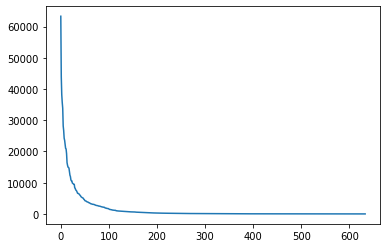

In [ ]:
genres_count.sort_values(ascending=False).reset_index(drop=True).plot();

In [ ]:
unique_item_tags = genres_count.sort_values(ascending=False)[:200].index
unique_item_tags[:10]

Index(['любовное фэнтези', 'попаданцы', 'современные любовные романы',
       'современные детективы', 'героическое фэнтези', 'боевая фантастика',
       'зарубежные любовные романы', 'боевое фэнтези',
       'современная русская литература', 'книги про волшебников'],
      dtype='object', name='genres')

In [ ]:
def filter_genres(genres_list, valid_genres=None):
    if not genres_list:
        return []
    return [genre for genre in genres_list if genre in valid_genres]

In [ ]:
%%time
i_features_lfm['features'] = i_features_lfm['genres'].apply(filter_genres, valid_genres=set(unique_item_tags))

CPU times: user 80.9 ms, sys: 185 µs, total: 81.1 ms
Wall time: 89.6 ms


In [ ]:
i_features_list = i_features_lfm['features']
i_features_list[:5]

item_id
23831    [зарубежные детские книги, сказки, зарубежная ...
39149    [классическая проза, литература 19 века, русск...
17678    [зарубежная классика, классическая проза, лите...
46007            [пьесы и драматургия, литература 19 века]
54532    [зарубежная классика, классическая проза, лите...
Name: features, dtype: object

#### LightFM Dataset
Посмотрим на то, как в каком формате принимает данные lightfm и как использовать Dataset для конвертации.

LightFM работает со sparse-матрицами, dataset конвертирует данные в coo-формат.
Матрица взаимодействий - это просто матрица размером количество пользователей $\times$ количество объектов.
Матрицы признаков выглядят интереснее.

In [ ]:
lfm_dataset = Dataset()

In [ ]:
lfm_dataset.fit_partial(users=filtered_df['user_id'].unique(), items=filtered_df['item_id'].unique())
lfm_dataset.fit_partial(user_features=unique_user_tags, item_features=unique_item_tags)

In [ ]:
user_mapping = lfm_dataset.mapping()[0]
user_f_mapping = lfm_dataset.mapping()[1]
item_mapping = lfm_dataset.mapping()[2]
item_f_mapping = lfm_dataset.mapping()[3]

In [ ]:
user_mapping

{47177: 0,
 98860: 1,
 58566: 2,
 39971: 3,
 139025: 997,
 18012: 998,
 132989: 999,
 ...}

In [ ]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

#### transform features

In [ ]:
sparse_i_features = lfm_dataset.build_item_features([[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()])
sparse_u_features = lfm_dataset.build_user_features([[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()])

In [ ]:
sparse_i_features.shape

(56752, 56952)

In [ ]:
sparse_i_features[0, :].nonzero(), sparse_i_features[0, :].data

((array([0, 0, 0, 0], dtype=int32),
  array([    0, 56761, 56767, 56789], dtype=int32)),
 array([0.25, 0.25, 0.25, 0.25], dtype=float32))

#### transform log

In [ ]:
%%time
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in train_by_date.itertuples()])

CPU times: user 2.68 s, sys: 154 ms, total: 2.84 s
Wall time: 2.87 s


Посмотрим на содержание матриц interactions и weights: использую матрицу interactions можно легко перейти от explicit feedback к implicit. Будем использовать weights, можете поэкспериментировать с interactions самостоятельно.

In [ ]:
len(interactions.row), len(interactions.col), interactions.data

(357518, 357518, array([1, 1, 1, ..., 1, 1, 1], dtype=int32))

Посмотрим на применение модели и воспроизведем подсчет релевантностей.

### model training

In [ ]:
%%time
lightfm = LightFM(no_components=64, loss='warp', random_state=SEED)
lightfm.fit(interactions, user_features=sparse_u_features, item_features=sparse_i_features, epochs=40, num_threads=8)

CPU times: user 3min 6s, sys: 97 ms, total: 3min 6s
Wall time: 1min 36s


### predict для одного пользователя

Посмотрим рекомендации для любителя боевой фанастики

In [ ]:
pred = lightfm.predict(user_ids=user_mapping[21], item_ids=sorted(item_mapping.values()), user_features=sparse_u_features, item_features=sparse_i_features)

In [ ]:
ids = np.argpartition(pred, -K)[-K:]
rel = pred[ids]
res = pd.DataFrame(zip(ids, rel), columns=['item_id', 'relevance'])
res['item_id'] = res['item_id'].map(inv_item_mapping)

In [ ]:
res.merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,popularity,title,genres,authors,year
9,50385,-116.808655,307,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018
8,16683,-117.050369,591,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015
4,44529,-117.353249,85,Ведьма-хранительница,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2003
5,39338,-117.380775,43,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011
3,59157,-117.380943,502,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05
6,22157,-117.404289,81,Верховная Ведьма,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2004
7,34563,-117.424194,51,Ночной Дозор,"Боевое фэнтези,Городское фэнтези",Сергей Лукьяненко,1998
2,51257,-117.534790,92,Профессия: ведьма,"Героическое фэнтези,Книги про волшебников,Юмор...",Ольга Громыко,2003
1,5950,-117.547539,90,Игра престолов,"Героическое фэнтези,Зарубежное фэнтези,Боевое ...",Джордж Мартин,1996
0,57154,-117.552040,151,Игра престолов. Часть I,"Зарубежное фэнтези,Боевое фэнтези",Джордж Мартин,1996


Посмотрите на рекомендации, все ли ок? Есть ли какие-то "лишние"книги?

## 8.1 Задание: посчитайте релевантность руками
посчитайте релевантность книги "Магический спецкурс. Второй семестр" (43272)  для пользователя 100017, который читает всякое такое.
Используйте методы get_item_representations(), get_user_representations(), которые есть у модели LightFM.

In [ ]:
i_features.loc[43272]

title                    Магический спецкурс. Второй семестр
genres     Любовно-фантастические романы,Попаданцы,Любовн...
authors                                          Лена Летняя
year                                                    2018
Name: 43272, dtype: object

In [ ]:
item_id_lfm = item_mapping[43272]
user_id_lfm = user_mapping[21]

In [ ]:
rel = lightfm.predict(user_ids=user_id_lfm, 
                      item_ids=[item_id_lfm], 
                      user_features=sparse_u_features, 
                      item_features=sparse_i_features)[0]
rel

-119.39244

Получили релевантность моделью, проверим, что поняли, как оно работает

Отлично, разобрались с тем, как использовать модели LightFM, давайте попробуем воспроизвестви подсчет релевантности. Для этого вернемся к формуле:

$$r_{ui} = <q_u , p_i> + b_u + b_i$$

$$q_u = \sum_{j \in f_u} e^U_j$$
$$ e^U_j = w^U_j  e_j$$ 
$$b_u = \sum_{j \in f_u} b^U_j$$
$$ b^U_j = w^U_j  b_j$$ 
где $q_u, p_i$ - вектора пользователя и объекта, являющиеся суммой векторов их признаков
$b_u, b_i$ - смещения для признаков пользователя и объекта


In [ ]:
u_biases, u_vectors = lightfm.get_user_representations()
u_vectors.shape, u_biases.shape

((37012, 64), (37012,))

In [ ]:
i_biases, i_vectors =lightfm.get_item_representations()
i_vectors.shape, i_biases.shape

((56952, 64), (56952,))

In [ ]:
# ======= YOUR CODE HERE ==========
user_vector = sparse_u_features[user_id_lfm]@u_vectors
item_vector = sparse_i_features[item_id_lfm]@i_vectors
rel_ours = (user_vector@item_vector.T + sparse_u_features[user_id_lfm]@u_biases + sparse_i_features[item_id_lfm]@i_biases).ravel()[0]

In [ ]:
assert math.isclose(rel, rel_ours, rel_tol=1e-5)

Все совпало, мы молодцы! Имея вектора пользователей и объектов, мы можем искать похожих, как делали это в ALS.

# 8.3 Задание: допишите predict, чтобы заработало 
(авторское решение использует apply для каждого пользователя)

In [ ]:
from typing import Dict, Iterable
class UserFriendlyLightFM(SVDModel):
    user_mapping: Dict
    user_f_mapping: Dict
    item_mapping: Dict
    item_f_mapping: Dict
    lightfm_dataset: Dataset
        
    def __init__(self, 
                 user_ids: np.ndarray, 
                 item_ids: np.ndarray,
                 user_tags: Optional[Iterable],
                 item_tags: Optional[Iterable],
                 epochs: int,
                 model: LightFM
                ):
        self.lightfm_dataset = Dataset()
        self.lightfm_dataset.fit(users=user_ids, 
                                         items=item_ids,
                                         user_features=user_tags,
                                         item_features=item_tags,
                                        )
        self.user_mapping = self.lightfm_dataset.mapping()[0]
        self.item_mapping = self.lightfm_dataset.mapping()[2]
        self.inv_user_mapping = {value: key for key, value in self.user_mapping.items()}
        self.inv_item_mapping = {value: key for key, value in self.item_mapping.items()}
        self.epochs = epochs
        self.model = model

        
    def _transform_dataset(self, 
                           log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None):
        
        (interactions, weights) = self.lightfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in log.itertuples()]) if log is not None else (None, None)
        user_features_sparse = self.lightfm_dataset.build_user_features([[row.user_id, row.features] for row in user_features.reset_index().itertuples()]) if user_features is not None else None
        item_features_sparse = self.lightfm_dataset.build_item_features([[row.item_id, row.features] for row in item_features.reset_index().itertuples()]) if item_features is not None else None
        return interactions, weights, user_features_sparse, item_features_sparse
    
    def fit(self, 
            log: pd.DataFrame, 
            user_features: Optional[pd.DataFrame]=None, 
            item_features: Optional[pd.DataFrame]=None) -> 'UserFriendlyLightFM':
        
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(log, user_features, item_features)
        self.model.fit(interactions, user_features=user_features_sparse, item_features=item_features_sparse, epochs=self.epochs, num_threads=8)

    def _predict(self, 
                log: pd.DataFrame, 
                users: pd.Series, 
                k: int,
                user_features: Optional[pd.DataFrame]=None, 
                item_features: Optional[pd.DataFrame]=None,
                filter_seen:bool = True) -> pd.DataFrame:
        
        pred = pd.DataFrame(users.map(self.user_mapping).unique(), columns=['user_id'])
        pred.dropna(inplace=True)
        interactions, weights, user_features_sparse, item_features_sparse = self._transform_dataset(None, user_features, item_features)
        
        
        # ======= YOUR CODE HERE ==========
        def _get_lfm_pred_all_items(user_id):
            pred_for_all = self.model.predict(user_ids=user_id, item_ids=sorted(self.item_mapping.values()), user_features=user_features_sparse, item_features=item_features_sparse)
            ids = np.argpartition(pred_for_all, -k)[-k:]
            rel = pred_for_all[ids]
            return list(zip(ids, rel))
    
        pred['recs'] = pred['user_id'].apply(_get_lfm_pred_all_items)
        pred = pred.explode('recs')
        self._split_pair(pred)
        # =================================
        pred['item_id'] = pred['item_id'].map(self.inv_item_mapping)
        pred['user_id'] = pred['user_id'].map(self.inv_user_mapping)
        return pred

## LightFM без признаков

In [ ]:
lfm = UserFriendlyLightFM(user_ids=filtered_df['user_id'].unique(), 
                             item_ids=filtered_df['item_id'].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=40,
                             model=LightFM(no_components=64, loss='warp'))

In [ ]:
%%time
lfm.fit(log=train_by_date, user_features=None, item_features=None)

CPU times: user 1min 32s, sys: 140 ms, total: 1min 32s
Wall time: 49.4 s


In [ ]:
%%time
lfm_pred = lfm.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=None, item_features=None)

CPU times: user 1min 15s, sys: 2.04 s, total: 1min 17s
Wall time: 1min 17s


In [ ]:
%%time
measure(lfm_pred, test_by_date, 'LightFM_rec_64_40_ep', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('hit_rate@K', ascending=False)

CPU times: user 1.23 s, sys: 194 ms, total: 1.43 s
Wall time: 1.71 s


,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
svd_rec,0.0226527,0.10998,0.0436336,0.0130446,0.0261136,0.633979
LightFM_rec_64_40_ep,0.0151018,0.0876559,0.0337902,0.00818675,0.10234,0.670153
neighbour_rec,0.0134603,0.086671,0.0315642,0.00904316,0.0319284,0.606857
popular,0.0026264,0.0223244,0.00662839,0.00134756,0.000317169,0.531123


## LightFM  c признаками

In [ ]:
lfm_uf = UserFriendlyLightFM(user_ids=filtered_df[user_id].unique(), 
                             item_ids=filtered_df[item_id].unique(),
                             user_tags=unique_user_tags,
                             item_tags=unique_item_tags,
                             epochs=40,
                             model=LightFM(no_components=256, loss='warp')
                            )

In [ ]:
%%time
lfm_uf.fit(log=train_by_date, item_features=i_features_list, user_features=u_features_list)

CPU times: user 8min 18s, sys: 396 ms, total: 8min 19s
Wall time: 4min 16s


In [ ]:
%%time
pred_feat = lfm_uf.predict(log=train_by_date, users=test_by_date_users, k=K, user_features=u_features_list, item_features=i_features_list)

CPU times: user 5min 18s, sys: 834 ms, total: 5min 19s
Wall time: 5min 18s


In [ ]:
%%time
measure(pred_feat, test_by_date, 'LightFM_rec_features_256_40', metrics, cov_items=filtered_df['item_id'], surp=surp).sort_values('hit_rate@K', ascending=False)

CPU times: user 1.27 s, sys: 113 ms, total: 1.38 s
Wall time: 1.66 s


,hit_rate@1,hit_rate@K,mrr@K,map@K,coverage@K,surprisal@K
svd_rec,0.0226527,0.10998,0.0436336,0.0130446,0.0261136,0.633979
LightFM_rec_128_40_ep,0.0170716,0.0942219,0.0359888,0.00898016,0.10123,0.669836
neighbour_rec,0.0134603,0.086671,0.0315642,0.00904316,0.0319284,0.606857
LightFM_rec_features_256_40,0.00919238,0.0669731,0.0234474,0.00479481,0.119714,0.690243
popular,0.0026264,0.0223244,0.00662839,0.00134756,0.000317169,0.531123


Итак, теперь у нас есть следующие модели:

- рекомендатель популярного
- knn на ассоциативных правилах
- svd
- lightFM
    
Но почему бы не решать задачу рекомендаций как задачу ранжирования или классификации с использованием популярных алгоритмов машинного обучения? В таком случае мы будем по вектору признаков пользователя и объекта предсказывать значение релевантности.
Вот некоторые причины:

- данных очень много, и на инференсе скорить все возможные пары пользователь-объект - очень долго
- чаще всего у нас нет класса 0 или этих данных мало, а значит, их нужно сэмплировать
- кажется, что модели будет сложно обобщить коллаборативную информацию, т.е. использовать информацию о предыдущих взаимодействиях, потому что на вход подается только одно взаимодействие

Как с этим бороться? 

- Использовать многоуровневые модели (например, ALS + градиентный бустинг/нейросеть)
    

In [ ]:
# 5 Session-based модели
Иногда мы 

примеры item-to-item моделей:
- поиск ближайших item-ов по признакам
- любой классификатор, обучающийся на датасете "признаки пользователя/сессии - признаки текущего item-а - признаки следующего item-а" с target "появился ли в сессии следующим"
- item-to-item knn на истории взаимодействий
- [нейронка item2vec от avito](https://habr.com/ru/company/avito/blog/491942/)
- классический word2vec, где вместо слов - item-ы, а вместо предложений - сессии
- [любый нейронки для последовательностей](https://medium.com/nvidia-merlin/transformers4rec-4523cc7d8fa8)

![nlp_recsys](https://miro.medium.com/max/1400/0*BYMSTEtMuf8Blk34)

[source](https://nvidia-merlin.github.io/Transformers4Rec/main/why_transformers4rec.html)

# 9 Двухуровневая модель

- Как разбить данные без лика?
- Сколько кандидатов генерировать и как?
- Какие признаки добавить для обучения модели второго уровня?
- Как переобучать весь ансамбль?

Примеры:
- [Рекомендации в Okko: как заработать сотни миллионов, перемножив пару матриц](https://habr.com/ru/company/okko/blog/454224/)
- [Rekko Challenge — как занять 2-е место в конкурсе по созданию рекомендательных систем](https://habr.com/ru/company/tinkoff/blog/454818/)
- [Дзен-митап: Объяснимые рекомендации](https://www.youtube.com/watch?v=ll-y6I_r_OM&t=357s)
- [Дзен-митап: Next-level recommendations — как сделать модель второго уровня в рекомендациях](https://www.youtube.com/watch?v=4NutBpiIHi0&t=1240s)
    
    

Буквально на днях команда MTS выложила лекцию про двухуровневую архитектуру - довольно понятно, быстро объясняется и с кодом.
Посмотрите [видео](https://ods.ai/tracks/recsys-course2021/blocks/34e6b8d3-5cf0-4ab8-9443-fbc14ad9cf0b) и [код](https://github.com/sharthZ23/your-second-recsys/tree/master/lecture_5).

Например, обучим SVD на 70% train, а вторым уровнем выберем Catboost, добавив в качестве признаков название, год выпуска книги и автора 

In [ ]:
!pip install --upgrade catboost

     |████████████████████████████████| 76.3 MB 21 kB/s 


### Разобъем данные

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Q = 0.7
train_first = train_by_date[train_by_date['start_date'] <= train_by_date['start_date'].quantile(Q)].copy()
train_second = train_by_date[train_by_date['start_date'] > train_by_date['start_date'].quantile(Q)].copy()
train_second = train_second[train_second['user_id'].isin(train_first['user_id'].unique())]
train_u_second, val_u_second = train_test_split(train_second['user_id'].unique(), test_size=0.1, random_state=SEED)

In [ ]:
train_second['target_cb'] = 1

In [ ]:
get_log_info(train_first)

Длина лога = 250664,
количество пользователей = 36083,
количество объектов = 51725


In [ ]:
get_log_info(train_second)

Длина лога = 101765,
количество пользователей = 24785,
количество объектов = 32282


## 9.1 Задание: Обучите SVD на данных train first и получите predict топ-100 объектов для пользователей из train_second

In [ ]:
%%time
# ======= YOUR CODE HERE ==========
first_level = SVDModel(rank=64)
first_level.fit(log=train_first, user_features=None, item_features=None)
first_level_pred = first_level.predict(log=train_first, users=pd.Series(train_second['user_id'].unique()), k=100, user_features=None, item_features=None, filter_seen=False)

CPU times: user 3min 31s, sys: 54.4 s, total: 4min 25s
Wall time: 2min 33s


## Задание 9.2 Добавьте столбец target_cb, содержащий метку класса

In [ ]:
# ======= YOUR CODE HERE ==========
first_level_pred = first_level_pred.merge(train_second[['user_id', 'item_id', 'target_cb']], on=['user_id', 'item_id'], how='left')
first_level_pred.fillna(0, inplace=True)

In [ ]:
first_level_pred.head(2)

,user_id,item_id,relevance,target_cb
0,31251,28890,0.006684,0.0
1,31251,58727,0.022607,0.0


In [ ]:
assert first_level_pred['target_cb'].sum() > 0

## Добавим признаки

In [ ]:
i_features['year_conv'] = i_features.loc[:, 'year'].str.extract(r'(\d{4})', expand=False).astype(float)

In [ ]:
CAT_COLS = [1, 2, 3]

def preprocess_cb(pd_df):
    full_feat = pd_df.merge(u_features, left_on='user_id', right_index=True, how='left')
    full_feat = full_feat.merge(i_features[['authors', 'year_conv']], left_on='item_id', right_index=True, how='left')
    target = full_feat['target_cb']
    full_feat['rank'] = full_feat.groupby('user_id')['relevance'].rank(method="first", ascending=False)
    ids = full_feat[['user_id', 'item_id']]
    cb_train = full_feat.drop(columns=['user_id', 'item_id', 'target_cb'])
    cb_train['sex'] = cb_train['sex'].astype('str')
    cb_train.iloc[:, CAT_COLS] = cb_train.iloc[:, CAT_COLS].fillna('nan')
    return cb_train, target, ids

In [ ]:
cb_train, target, ids = preprocess_cb(first_level_pred)

In [ ]:
cb_train.head(2)

,relevance,age,sex,authors,year_conv,rank
0,0.006684,55_64,0.0,Маргарита Гришаева,2018.0,65.0
1,0.022607,55_64,0.0,Елена Звёздная,2014.0,8.0


## Обучим Catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
catcls = CatBoostClassifier(iterations=30)

In [ ]:
%%time
cb_fitted = catcls.fit(cb_train[first_level_pred['user_id'].isin(train_u_second)], 
                       target[first_level_pred['user_id'].isin(train_u_second)], 
                       eval_set=(cb_train[~first_level_pred['user_id'].isin(train_u_second)], 
                       target[~first_level_pred['user_id'].isin(train_u_second)]),
                       cat_features=[1, 2, 3], 
                       early_stopping_rounds=10)

Learning rate set to 0.5
0:	learn: 0.3182613	test: 0.3182128	best: 0.3182128 (0)	total: 1.16s	remaining: 33.5s
1:	learn: 0.1778659	test: 0.1777864	best: 0.1777864 (1)	total: 1.66s	remaining: 23.3s
2:	learn: 0.1073325	test: 0.1072259	best: 0.1072259 (2)	total: 2.09s	remaining: 18.9s
3:	learn: 0.0686683	test: 0.0685169	best: 0.0685169 (3)	total: 3.02s	remaining: 19.6s
4:	learn: 0.0468121	test: 0.0466294	best: 0.0466294 (4)	total: 3.53s	remaining: 17.7s
5:	learn: 0.0342975	test: 0.0340743	best: 0.0340743 (5)	total: 4s	remaining: 16s
6:	learn: 0.0271132	test: 0.0267823	best: 0.0267823 (6)	total: 4.73s	remaining: 15.5s
7:	learn: 0.0228586	test: 0.0224458	best: 0.0224458 (7)	total: 5.51s	remaining: 15.1s
8:	learn: 0.0204577	test: 0.0199999	best: 0.0199999 (8)	total: 5.99s	remaining: 14s
9:	learn: 0.0191215	test: 0.0186268	best: 0.0186268 (9)	total: 6.76s	remaining: 13.5s
10:	learn: 0.0183360	test: 0.0177853	best: 0.0177853 (10)	total: 7.33s	remaining: 12.7s
11:	learn: 0.0179089	test: 0.01731

In [ ]:
imp = list(zip(catcls.feature_names_, catcls.feature_importances_))
imp.sort(key=lambda x: -x[1])
imp

[('relevance', 72.68270034490074),
 ('sex', 9.581024893972435),
 ('age', 7.624381322865657),
 ('rank', 6.7608557683958015),
 ('year_conv', 3.3510376698653843),
 ('authors', 0.0)]

### Получим predict

In [ ]:
first_level_pred_for_test = first_level.predict(log=train_by_date[train_by_date['user_id'].isin(test_by_date_users.values)], users=pd.Series([21], name='user_id'), k=100)
first_level_pred_for_test['target_cb'] = 0
cb_for_test, target_for_test, ids_for_test = preprocess_cb(first_level_pred_for_test)

In [ ]:
cb_pred = catcls.predict_proba(cb_for_test)
ids_for_test['relevance'] = cb_pred[:, 1]
res = filter_seen_items(train_by_date, ids_for_test)
res = leave_top_k(res, k=K)

In [ ]:
res.merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,user_id,item_id,relevance,popularity,title,genres,authors,year
6,21,27304,0.002732,161,Шестой Дозор,"Городское фэнтези,Книги про вампиров",Сергей Лукьяненко,2014
3,21,56368,0.001722,114,Новый Дозор,"Боевое фэнтези,Городское фэнтези",Сергей Лукьяненко,2012
0,21,50905,0.001171,390,Чистовик,Научная фантастика,Сергей Лукьяненко,2007
1,21,13068,0.001171,46,Танцы на снегу,"Космическая фантастика,Научная фантастика",Сергей Лукьяненко,1999-2001
4,21,57410,0.001165,39,КВАЗИ,"Социальная фантастика,Детективная фантастика",Сергей Лукьяненко,2016
5,21,21461,0.001165,73,Самоволка,"Боевая фантастика,Попаданцы","Сергей Лукьяненко,Михаил Тырин",2014
2,21,27614,0.001159,191,Магическая Экспедиция,"Книги про волшебников,Любовное фэнтези,Фэнтези...",Елена Звёздная,2018
9,21,11395,0.001158,175,Магическая сделка,"Книги про волшебников,Любовное фэнтези,Фэнтези...",Елена Звёздная,2018
7,21,10247,0.001146,45,Холодные берега,Историческая фантастика,Сергей Лукьяненко,1998
8,21,52766,0.001124,40,Конкуренты,Космическая фантастика,Сергей Лукьяненко,2008


Добавим каких-нибудь признаков, например: 
- как давно последний раз читали эту книгу
- для книг этого автора от общего числа прочтенных
- популярность книги
- вектора пользователей и айтемов из модели 1 уровня

Возможность погенерировать признаки и использовать на первом уровне не одну модель, а несколько, еще ждет вас в лабе/конкурсе.

Почитать о том, какие признаки можно генерировать для обучения двухуровневой модели на задачу рекомендаций можно в статьях с решениями конкурсов из раздела про LighFM

# 10 Нейросети: MultVAE

- Нейроколлаборативная матричная факторизация
- Embeddings + MLP на признаках, обучающиеся на вероятность клика/релевантность 
- Рекуррентые сети
- Трансформеры
- Автокодировщики

Несколько названий: DSSM, DLRM, Wide&Deep, DeepFM, Deep&Cross

Почему MultVAE? Выглядит элегантно + с ним часто сравниваются в статьях!)

![multvae](https://sberbank-ai-lab.github.io/RePlay/_images/vae-gaussian.png)

Подаем на вход:
- Историю пользователя (вектор из 0 и единиц)

Хотим получить:
- Восстановленный x, содержащий релевантности для объектов, с которыми не было взаимодействий (берем Softmax от выходов decoder-а)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

### подготовка данных

In [ ]:
class MultVAEDataset(Dataset):
    def __init__(self, X, item_count):
        self.item_count = item_count
        # introduce new user ids to reduce sparse matrix size
        self.user_mapping = {i: u_id for i, u_id in enumerate(X["user_id"].unique())}
        self.inverse_users_mapping ={u_id: number for number, u_id in self.user_mapping.items()}
        self.X = csr_matrix((
                np.ones(len(X["user_id"])),
                (X["user_id"].map(self.inverse_users_mapping).values, X["item_id"].values)),
                shape=(len(self.user_mapping), self.item_count))
        
        
    def __len__(self):
        return len(self.user_mapping)

    def get_vector(self, u_id):
        return self.X[self.inverse_users_mapping[u_id]].toarray().ravel().astype('float32')

    def __getitem__(self, idx):
        return self.X[idx].toarray().ravel().astype('float32'), self.user_mapping[idx]

In [ ]:
from sklearn.model_selection import train_test_split
train_u_mult, val_u_mult = train_test_split(train_by_date['user_id'].unique(), test_size=0.2, random_state=SEED)
X_train = train_by_date[train_by_date['user_id'].isin(train_u_mult)]
X_val = train_by_date[train_by_date['user_id'].isin(val_u_mult)]

In [ ]:
vector_len = train_by_date['item_id'].max() + 1
train_dataset = MultVAEDataset(X_train, vector_len)
val_dataset = MultVAEDataset(X_val, vector_len)

In [ ]:
batch_size = 1024
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
%%time
test_b = next(iter(train_dl))
assert test_b[0].size() == (batch_size, vector_len)

CPU times: user 350 ms, sys: 476 ms, total: 826 ms
Wall time: 972 ms


### архитектура сетки

####Задание: 
если вы еще живы, набросайте свою архитектуру согласно картинке и статье. Можно использовать такие размерности линейных слоев: 

энкодер: I(число item-ов)→600→200*2

декодер: 200→600→I.

Получив из энкодера вектор длины 200*2, используйте первые 200 значений значений как $\mu$ многомерного распределения, а оставшиеся как $log(variance)$.
Обратите внимание, что мы сэмплируем латентное представление во время обучения, а для inference используем только значения $\mu$.

Выделите encoder/decoder как отдельные атрибуты модели. 

In [ ]:
class MultVAE(nn.Module):
    def __init__(self, input_size, latent_size, drop=0.2):
        self.latent = latent_size
        super().__init__()
        # ======= YOUR CODE HERE ==========
        self.encoder = nn.Sequential(
                    nn.Dropout(drop),
                    nn.Linear(input_size, latent_size * 4),
                    nn.ReLU(),
                    nn.Linear(latent_size * 4, latent_size * 2)
        )
        # =================================
        
        # ======= YOUR CODE HERE ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size * 4),
            nn.ReLU(),
            nn.Linear(latent_size * 4, input_size),
        )
        # =================================
        
    def encode(self, batch):
        x = F.normalize(batch, dim=1)
        mu_logvar = self.encoder(x)
        mu = mu_logvar[:, : self.latent]
        logvar = mu_logvar[:, self.latent :]
        return mu, logvar

    def decode(self, batch):
        return self.decoder(batch)


    def forward(self, batch):
        # ======= YOUR CODE HERE ==========
        mu, logvar = self.encode(batch)
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            latent = mu + std * eps
        else:
            latent = mu
        output = self.decode(latent)
        # ======= YOUR CODE HERE ==========
        return output, mu, logvar

### loss
Будем использовать evidence lower bound(ELBO) loss function с гиперпараметром $\beta$, позволяющем настраивать степень регуляризации (влияния KL-дивергенции).

Максимизация логправдоподобия:

$$
\log p_{\theta}(\mathbf{X}) = \sum_u \log p_{\theta}(\mathbf{x}_u) 
$$

Может быть представлена в виде (за более развернутым объяснением можно обратиться, например, к [туториалу](https://colab.research.google.com/github/jrzaurin/infinitoml/blob/master/_notebooks/2020-05-15-mult-vae.ipynb):
$$
\mathcal L(\mathbf{\text{X}}^M, \phi,\theta) \simeq \frac{1}{M} \sum_{u=1}^{M} - D_{KL}\left(q_\phi(\textbf{z}_u\vert \textbf{x}_u) \| p_\theta(\textbf{z}_u \right) + \log  p_{\theta}(\mathbf{x}_u \vert \mathbf{z}_u)
$$

Пусть мы получаем на выходе сети $\pi(\mathbf{z}_u)$:
$$\pi(\mathbf{z}_u) = Softmax(MLP(\mathbf{z}_u))$$

$x_u$ имеет мультиномиальное распределение:
$$
\textbf{x}_u \sim \text{Mult}(N_u, \pi(\mathbf{z}_u))
$$

Тогда первый компонент функции потерь представим в виде:
$$
\begin{equation*}
\log(p_{\theta}(\textbf{x}_u\vert \textbf{z}_u)) = \mathbf{x}_u \log(\pi(\mathbf{z}_u))
\end{equation*}
$$

Распределение для $z_u$ - стандартное нормальное.
$$p(\textbf{z}_u) \sim \mathcal N(0, I)$$

То будем считать KL-дивергенцию для двух нормальных распределений, одно из которых стандартное:
$$KL(q_\phi(z | x) || p(z)) = -\frac{1}{2}\sum_{j=1}^{dimZ}(1+
log(\sigma_j^2) - \mu_j^2-\sigma_j^2)$$


Получим такую функцию потерь, которую и предлагается закодить:
$$
Loss = -\frac{1}{M} \sum_{u=1}^{M} \left[ \mathbf{x}_u \log(\pi(\mathbf{z}_u)) + \frac{\beta}{2}  \sum_{j=1}^{dimZ}( 1 + \log(\sigma_{uj}^2) - \mu_{uj}^2 - \sigma_{uj}^2 )  \right]
$$




Более развернуто и строго о loss для MultVAE можно почитать в [статье](https://arxiv.org/pdf/1802.05814.pdf), [в подробном туториале](https://colab.research.google.com/github/jrzaurin/infinitoml/blob/master/_notebooks/2020-05-15-mult-vae.ipynb) и [документации к одной из реализаций](https://sberbank-ai-lab.github.io/RePlay/pages/modules/models.html#mult-vae).

In [ ]:
def mult_vae_loss(y_pred, y_true, mu, logvar, anneal):
    # ======= YOUR CODE HERE ==========
    log_softmax_var = F.log_softmax(y_pred, dim=1)
    neg_ll = -(log_softmax_var * y_true).sum(dim=1).mean()
    kld = (
            -0.5
            * torch.sum(
                1 + logvar - mu.pow(2) - logvar.exp(),
                dim=1,
            ).mean()
        )
    # =================================
    return neg_ll + anneal * kld

### обучение/валидация

In [ ]:
from tqdm.notebook import tqdm
ANNEAL = 0.2

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for batch, ids in tqdm(loader):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out, mu, logvar = model(batch)
        loss = criterion(out, batch, mu, logvar, ANNEAL)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for batch, ids in tqdm(loader):
            batch = batch.to(device)
            
            out, mu, logvar = model(batch)
            loss = criterion(out, batch, mu, logvar, ANNEAL)

            losses_val.append(loss.item())
    
    return np.mean(losses_val)

### цикл обучения

In [ ]:
import matplotlib.pyplot as plt

from IPython.display import clear_output
from tqdm.notebook import trange


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, separate_show=False):
    losses = {'train': [], 'val': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2 if separate_show else 1, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            if separate_show:
                plt.subplot(121)
                plt.title('loss on train')
            # plt.yscale('log')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.legend()

            if separate_show:
                plt.subplot(122)
                plt.title('loss on validation')
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = MultVAE(vector_len, 300)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

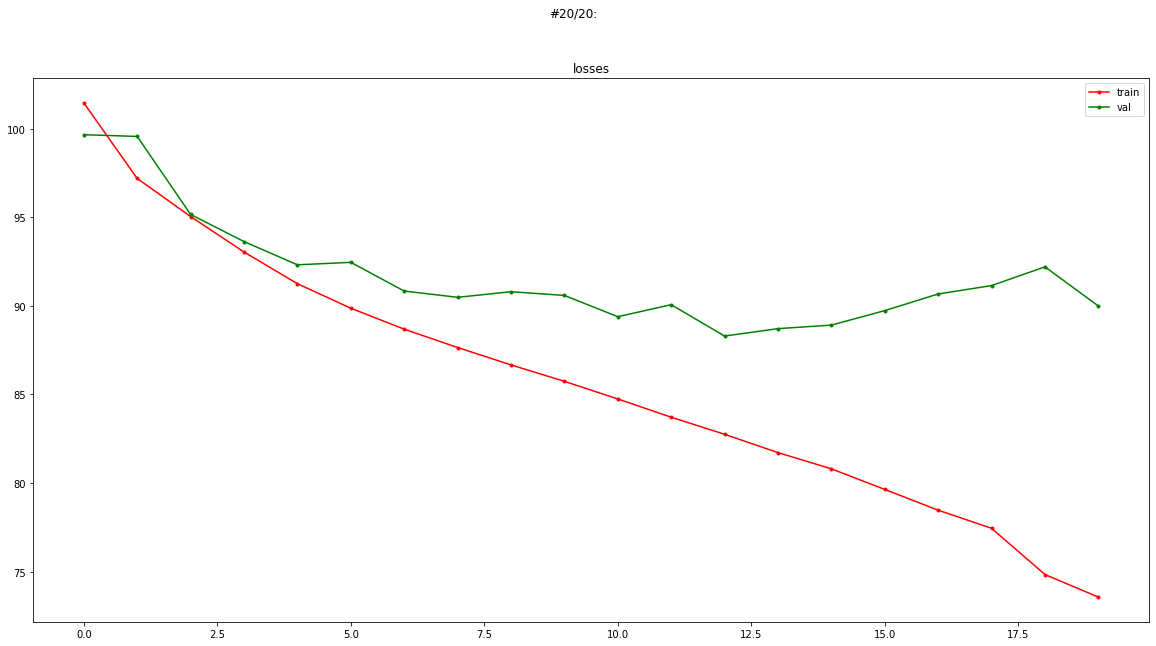

In [ ]:
model, optimizer, losses = learning_loop(model=model, 
              optimizer=optimizer, 
              train_loader=train_dl, 
              val_loader=valid_dl, 
              criterion=mult_vae_loss, 
              scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True), 
              min_lr=1e-6, 
              epochs=20, 
              val_every=1, 
              draw_every=1, 
              separate_show=False)

Это упрощенная реализация модели, для более хорошего результата можно заняться, например, подбором параметров или настройкой anneal по расписанию.

In [ ]:
output= model(torch.tensor(train_dataset.get_vector(21)).reshape(1, -1).to(device))[0].detach().cpu().numpy().flatten()
ids = np.argpartition(output, -(seen + K))[-(seen + K):]
rel = output[ids]
res = pd.DataFrame({'item_id' : ids, 'relevance': rel})
res['user_id'] = 21
pred_21 = filter_seen_items(X_train, res)
pred_21 = leave_top_k(res, K)

In [ ]:
pred_21.merge(i_features, on='item_id')

,item_id,relevance,user_id,title,genres,authors,year
0,19477,3.258822,21,Заклинатели,"Героическое фэнтези,Боевое фэнтези,Книги про в...","Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2011
1,8376,3.117702,21,Крадущийся в тени,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2001-2002
2,7211,2.868546,21,Проклятый горн,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
3,2459,3.422480,21,Джанга с тенями,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2002
4,30374,3.444483,21,Вьюга теней,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2003
5,10074,2.998956,21,Ветер и искры (сборник),"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2005-2008
6,13389,2.979045,21,Страж,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2010
7,48430,2.671822,21,Летос,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
8,39338,3.449306,21,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011
9,12691,2.978958,21,Ловушка для духа,"Героическое фэнтези,Боевое фэнтези,Книги про в...","Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2016


# Выводы
- мы поговорили про особенности задачи, метрики и разнообразные требования к рекомендательным системам
- получили примеры кода для моделей и подсчета метрик, которые могут быть полезны в лабе и конкурсе
- попробовали SVD, ALS, LightFM
- поговорили немного про двухуровневые архитектуры
- поняли, что рекомендательные системы - это не только матричная факторизация. Можно учить нейронки, хотя до сих пор в конкурсах часто побеждает бустинг со сложной генерацией признаков.
- все архитектуры рекомендательных систем уже реализовали и выложили на гитхаб до нас, и надо просто найти нужную библиотеку) Например: [NVIDIA-Merlin](https://github.com/NVIDIA-Merlin/Merlin), [MS recommenders](https://github.com/microsoft/recommenders), [RecBole](https://github.com/RUCAIBox/RecBole), [Elliot](https://github.com/sisinflab/elliot), [RePlay](https://github.com/sberbank-ai-lab/RePlay).

In [198]:
!pip freeze > requirements.txt